In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jax.scipy.optimize import minimize 
from LombScargle import periodogram, psd
from hypothesis_testing.bayes_factor import logB
from quasars import prep

from simulations.util import  *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


53
336.83572


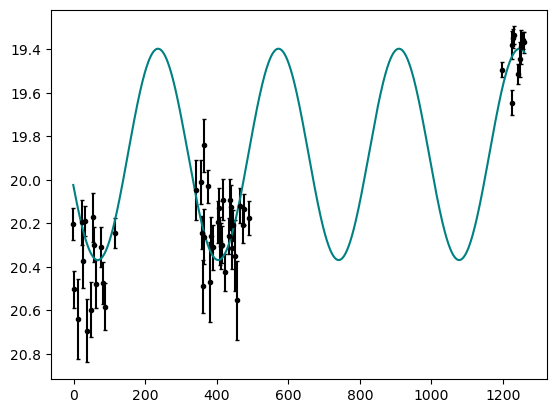

In [7]:
id = 411886
#id = 253736
time, mag, mag_err, freq, prior_params = prep.prepare_data(id)
print(len(time))

score_white, amps = jax.vmap(periodogram.lomb_scargle(time, mag, True, mag_err))(freq)
ibest = jnp.argmax(score_white)
score_white, amp = score_white[ibest], amps[ibest]
freq_best = freq[ibest]
print(1./freq_best)
tshift = 55008
plt.errorbar(time-tshift, mag, mag_err, fmt = '.', capsize = 1.3, color= 'black')
t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
model= periodogram.fit(t, freq_best, amp)
plt.plot(t-tshift, model, color = 'teal')
plt.gca().invert_yaxis()
plt.show()

In [2]:
scratch = '/pscratch/sd/j/jrobnik/quasars/'
id = jnp.load(scratch + 'ids.npy') # a random id



35383


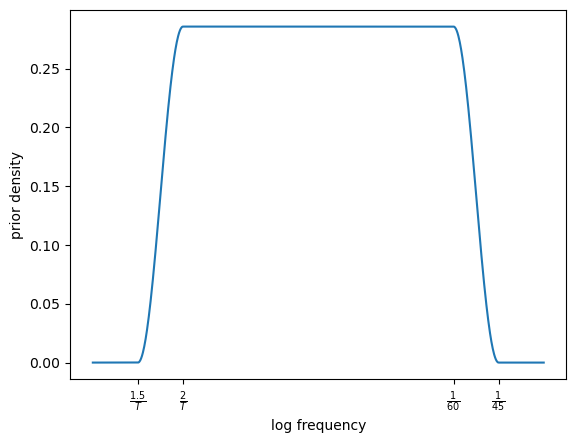

In [8]:

def uniform_with_smooth_edge(a, b, h):
    """Uniform prior with smooth edges.
        Uniform in the range [a, b] and decays to zero in the regions [a-h, a] and [b, b+h].
        Normalization constant is 1/ (b - a + h).
        Returns:
            nlogp function, taking x and returning -log p(x)
    """
    
    nlog_normalization = jnp.log(b-a+h)
    c = (b-a) * 0.5
    
    def nlogp(x):
        centered_x = x - (a + c)
        y = (jnp.abs(centered_x) - c) / h
        edge = 0.5 * ( 1 + jnp.cos(jnp.pi * y))
        return jax.lax.select(y < 1, ((y >= 0) * edge + (y < 0.)) / jnp.exp(nlog_normalization), jnp.zeros(y.shape))
    
    ### we generate samples by rejection sampling with the uniform distribution proposal 
    
    def importance_weight(x):
        centered_x = x - (a + c)
        y = (jnp.abs(centered_x) - c) / h
        edge = 0.5 * ( 1 + jnp.cos(jnp.pi * y))
        return jax.lax.select(y < 0, 1., edge)
    
    def proposal(state):
        _, _, key = state
        key1, key2, key3 = jax.random.split(key, 3)
        x = jax.random.uniform(key1, minval= a - h, maxval= b + h)
        acc_prob = importance_weight(x)
        reject = jax.random.bernoulli(key2, 1.-acc_prob).astype(bool)
        return x, reject, key3

    def generate(key):
        cond = lambda state: state[1]
        init= (0., True, key)
        state= jax.lax.while_loop(cond, proposal, init)
        return state[0]
    
    return nlogp, generate



p, g = uniform_with_smooth_edge(4., 7., 0.5)
key = jax.random.PRNGKey(0)


X = jax.vmap(g)(jax.random.split(key, 10000))
x = jnp.linspace(3, 8, 1000)

plt.plot(x, p(x))
#plt.hist(np.array(X), bins = 30, density= True)
plt.ylabel('prior density')
plt.xlabel('log frequency')
plt.xticks([3.5, 4., 7, 7.5], [r'$\frac{1.5}{T}$', r'$\frac{2}{T}$', r'$\frac{1}{60}$', r'$\frac{1}{45}$'])
plt.show()

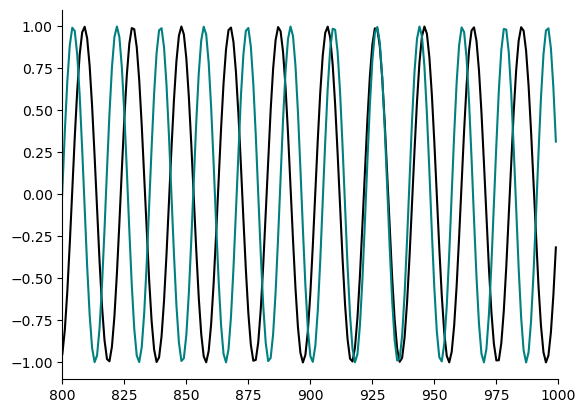

In [12]:
from simulations.synthetic import lee3_freq, time_sampling


get_time = time_sampling['equal'][1]
time, freq = get_time()
freqnull= drifting_freq(time, freq)

s = periodogram.lomb_scargle(time, freq[50])[0]
s3 = periodogram.lomb_scargle(time, freqnull[50])[0]

#plt.plot(time, s, color = 'black')
plt.plot(time, s3)
plt.xlim(800, 1000)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


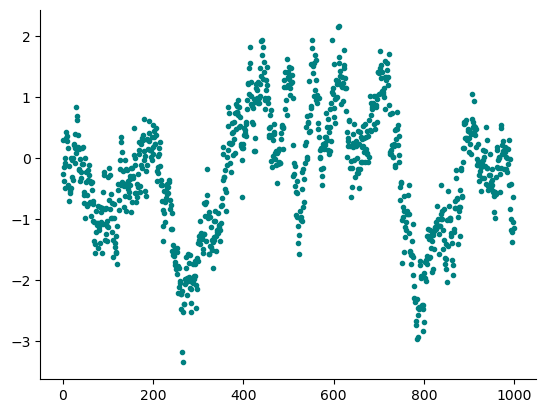

In [1]:
from simulations.synthetic import *

key = jax.random.PRNGKey(42)

get_time = time_sampling['equal'][1]
get_data = noise['correlated'][1]

time, freq = get_time()

data = get_data(key, time)
# score, _ = jax.vmap(periodogram.func(time, data))(freq)
# return jnp.max(score)


plt.plot(time, data, '.')
plt.show()

In [3]:
known = pd.read_csv('quasars/known.csv')
data= pd.read_csv('data/data.csv')
data= data.sort_values('myid')
period = np.array(data['period'])
period0 = np.array(known['period'])


print(period[13], period0[13])

654.4673 309.7


In [18]:
# setup
key = jax.random.PRNGKey(42)

scratch = '/pscratch/sd/j/jrobnik/quasars/'
id = jnp.load(scratch + 'ids.npy')# a random id
print(len(id))
#id = jnp.array(pd.read_csv('quasars/known.csv')['id'], dtype= int)[4]

#hyp = jnp.array([0.1, 120.])
    
df = pd.read_csv(scratch + str(id) + '.csv')
time = jnp.array(df['time'])
mag = jnp.array(df['mag'])
mag_err = jnp.array(df['mag_err'])
#key_time, key_data = jax.random.split(key)
#time= jax.random.uniform(key_time, shape = (1000,)) * 2000
#mag_err= jnp.ones(time.shape) * 0.0

#cov = psd.covariance(time, psd.drw_kernel(*hyp), mag_err)
T = jnp.max(time) - jnp.min(time)
fmin, fmax = 1./T, 1./60.
freq = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), 1000)
#data = irregular_spaced(key, cov)

#print(logB(time, data, mag_err, freq))

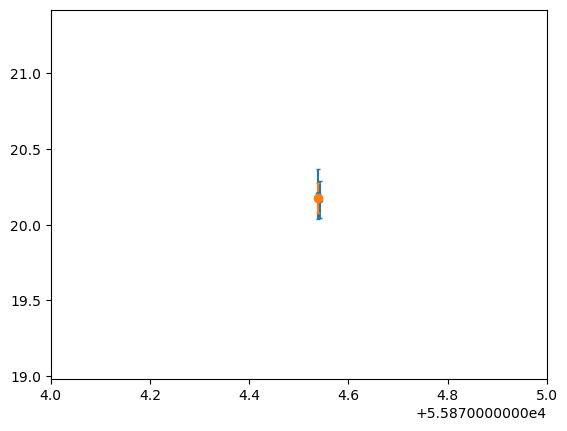

In [22]:
plt.errorbar(time, mag, yerr= mag_err, capsize = 1.1, fmt = '.')
Time, Mag, Mag_err = average_within_night(time, mag, mag_err)
plt.errorbar(Time, Mag, yerr= Mag_err, capsize = 1.5, fmt = 'o')
plt.xlim(55874, 55875)
plt.show()

2041


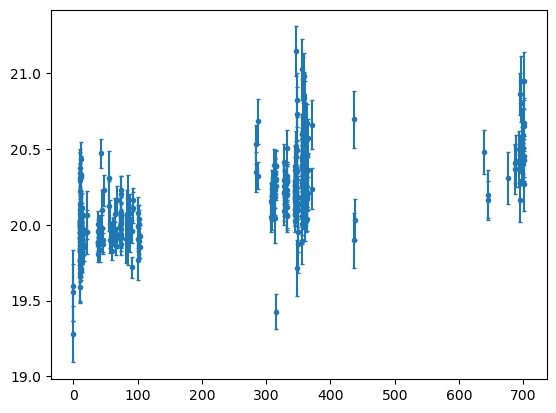

In [3]:
plt.errorbar(time-jnp.min(time), mag, yerr= mag_err, capsize = 1.5, fmt = '.')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(1./freq, score)
plt.xlabel('period [days]')
plt.ylabel('periodogram score')
plt.savefig('myid_'+str(myid)+'.png')
plt.close()